# Sentiment in tweet using supervised and unsupervised techniques

Can you imagine going through a pandemic without the Internet? Society quickly adjusted from in-person activities to strictly digital, resulting in a never before seen spike of remote work, online shopping, e-learning, and digital media consumption. The Internet has become a platform to drive innovation of everyday necessities. Social networking sites, like Twitter, Facebook, and TikTok, are critical avenues where individuals disseminate information and opinions to a global audience at record speeds. Some posts on social media “go viral”, meaning that they are shared so frequently over a short period of time reaching huge audiences. Individuals tend to be highly sensitive and reactive to topics such as politics, religion, entertainment, sports, and even products. When the discourse around your company's product or service is positive and spreads quickly, it can be a huge boost to business. On the contrary, any negative discourse that spreads rapidly could cause irreparable damage. 

In this notebook we explore how to prepare the Twitter dataset, create new features and transform the text data to numerical data. Finally, we build a traditional classification model, as opposed to a more advanced deep learning algorithm. We are also going to implement an unsupervised sentiment analysis model to showcase how sentiment can be obtained without the need for labeled data.

The dataset is from kaggle and can be found: [here](https://www.kaggle.com/jp797498e/twitter-entity-sentiment-analysis/tasks).

In [1]:
import sys  
sys.path.append('../src/visualization')
sys.path.append('../src/processing')

In [2]:
sys.path

['/Users/elizabethdinevski/asset-dev/sentiment_analysis/notebooks',
 '/Users/elizabethdinevski/asset-dev/sentiment_analysis_tensorflow/env/lib/python38.zip',
 '/Users/elizabethdinevski/asset-dev/sentiment_analysis_tensorflow/env/lib/python3.8',
 '/Users/elizabethdinevski/asset-dev/sentiment_analysis_tensorflow/env/lib/python3.8/lib-dynload',
 '',
 '/Users/elizabethdinevski/.local/lib/python3.8/site-packages',
 '/Users/elizabethdinevski/asset-dev/sentiment_analysis_tensorflow/env/lib/python3.8/site-packages',
 '../src/visualization',
 '../src/processing']

In [3]:
%matplotlib inline

#Data management
import re
import pandas as pd
import numpy as np
from collections import Counter
from wordcloud import WordCloud

from TextFeatureEngineering import *
from DataCleansing import *

#TextBlob Features
from textblob import TextBlob

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('words')


#Tensorflow / Keras
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

np.random.seed(0)

import warnings
warnings.simplefilter("ignore")

Importing the Dependencies and Loading the Data

In [4]:
# Loading training dataset
path = '../data/external/twitter_training.csv'
train_df = pd.read_csv(path, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])

# Loading testing dataset
test_path = '../data/external/twitter_validation.csv'
test_df = pd.read_csv(test_path, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])

The data dimensions from the training dataset. We have 74,682 tweets for training with 4 attributes. The attributes are:
 * 'Tweet_ID': unique identifier for a particular tweet
 * 'Entity': the topic that the tweet pertains to
 * 'Sentiment': a classification of the tweet’s sentiment
 * 'Tweet_Content': the body of text associated with the tweet

In [5]:
train_df.sample(5)

,Tweet_ID,Entity,Sentiment,Tweet_Content
28696,537,ApexLegends,Neutral,"plus, why does it not fucking probably matter ..."
51606,10459,RedDeadRedemption(RDR),Neutral,This look like the starting scene of Red Dead ...
19463,12532,WorldOfCraft,Positive,Talking stocks an World of Warcraft in the AM ...
26251,907,AssassinsCreed,Positive,Clothes of the Brotherhood
55871,2390,CallOfDuty,Negative,@Activision so the last update literally broke...


In [6]:
n_reviews, n_attributes = train_df.shape
print('Total tweets in training dataset: ',n_reviews)
print('Total attributes in training dataset: ',n_attributes)

Total tweets in training dataset:  74682
Total attributes in training dataset:  4


The data dimensions from the testing dataset. We have 1,000 tweets for testing with 
4 attributes.

In [7]:
test_df.sample(5)

,Tweet_ID,Entity,Sentiment,Tweet_Content
12,11783,Verizon,Negative,"@FredTJoseph hey fred, Comcast cut the cable a..."
321,6569,Fortnite,Irrelevant,I haven’t watched the NBA in quiet some time. ...
561,3421,Facebook,Negative,WHY DOES IT HAVE THREE VERSIONS WTF 😭😭😭😭
430,5716,HomeDepot,Negative,@HomeDepot I slightly hate y’all for wasting m...
324,127,Amazon,Neutral,"""Great storytelling, peppered with detail that..."


In [8]:
n_reviews, n_attributes = test_df.shape
print('Total tweet in testing dataset: ',n_reviews)
print('Total attributes in testing dataset: ',n_attributes)

Total tweet in testing dataset:  1000
Total attributes in testing dataset:  4


# Exploratory Data Analysis

## Handling Missing Data

Missing data can skew anything for data scientists. After all, any analysis is only as good as the data. A data scientist doesn’t want to produce biased estimates that lead to invalid results. When dealing with missing data, data scientists must understand why the data is missing. Some consideration:

* Data Missing at Random? (MAR)
* Missing Completely at Random? (MCAR)
* Missing Not at Random? (NMAR)

There are many approaches for dealing with missing data:

* Deleting data
* Imputation

When data is missing, it may make sense to delete data, as mentioned above. However, that may not be the most effective option. For example, if too much information is discarded, it may not be possible to complete a reliable analysis.

Instead of deletion, data scientists have multiple solutions to impute the value of missing data. Depending why the data are missing, imputation methods can deliver reasonably reliable results.

For simplicity, we opted to reduce all the features that contain missing values.

The code below shows all the features with missing values in percentage.

In [9]:
missing_values = train_df.isna().mean().round(4) * 100
print('%s%%' % missing_values)

Tweet_ID         0.00
Entity           0.00
Sentiment        0.00
Tweet_Content    0.92
dtype: float64%


In [10]:
missing_values = test_df.isna().mean().round(4) * 100
print('%s%%' % missing_values)

Tweet_ID         0.0
Entity           0.0
Sentiment        0.0
Tweet_Content    0.0
dtype: float64%


In [11]:
train_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


The 'Tweet_Content' feature has 0.92% missing values. Becuase that is such a small amount, we will simply drop those rows that do not contain any Tweet content.

In [12]:
train_df = train_df.dropna()

In [13]:
missing_values = train_df.isna().mean().round(4) * 100
print('%s%%' % missing_values)

Tweet_ID         0.0
Entity           0.0
Sentiment        0.0
Tweet_Content    0.0
dtype: float64%


In the graph below, we look at the distribution of the sentiment classes throughout the training dataset. We notice that there are slightly higher negative tweets than other sentiments. Having 4 unique classes (positive, neutral, negative, and irrelevant) indicates that we have a multi-class problem. Overall, all of the classes are pretty balanced.

<BarContainer object of 4 artists>

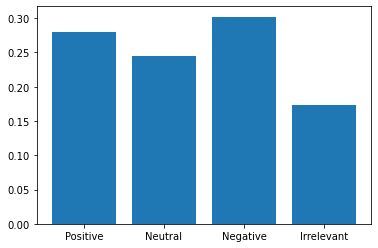

In [14]:
#Checking balance of target classes
sentiments = list(train_df["Sentiment"].unique())

sentiment_nums = [len(train_df[train_df["Sentiment"] == sentiment]) / len(train_df) for sentiment in sentiments]

plt.bar(sentiments, sentiment_nums)

Because we are dealing with 4 unique classes, let's assign a nomial value to each category. We are assigning the following values to each category:
 * 0: Neutral
 * 1: Irrelevant
 * 2: Negative
 * 3: Positive

In [15]:
#Define the indexing for each possible label in a dictionary
class_to_index = {"Neutral":0, "Irrelevant":1, "Negative":2, "Positive": 3}

#Creates a reverse dictionary
index_to_class = dict((v,k) for k, v in class_to_index.items())

#Creates lambda functions, applying the appropriate dictionary
names_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_names = lambda n: np.array([index_to_class.get(x) for x in n])

In [16]:
#Test each function
print(names_to_ids(["Positive", "Negative", "Irrelevant", "Neutral"]))
print(ids_to_names([0,1,2,3]))

[3 2 1 0]
['Neutral' 'Irrelevant' 'Negative' 'Positive']


In [17]:
#Convert the "Sentiment" column into indexes
train_df["Sentiment"] = names_to_ids(train_df["Sentiment"])
test_df["Sentiment"] = names_to_ids(test_df["Sentiment"])

In [18]:
train_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,2401,Borderlands,3,im getting on borderlands and i will murder yo...
1,2401,Borderlands,3,I am coming to the borders and I will kill you...
2,2401,Borderlands,3,im getting on borderlands and i will kill you ...
3,2401,Borderlands,3,im coming on borderlands and i will murder you...
4,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...


In [19]:
test_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,3364,Facebook,1,I mentioned on Facebook that I was struggling ...
1,352,Amazon,0,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,2,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,2,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,0,Now the President is slapping Americans in the...


Let's check for the total duplicate occurrences and remove them.

In [20]:
dup = train_df.duplicated().sum()
print('Number of duplicates in dataset: ', dup)

Number of duplicates in dataset:  2340


In [21]:
dup = train_df.duplicated().sum()
print('Number of duplicates in dataset: ', dup)

Number of duplicates in dataset:  2340


In [22]:
dup = test_df.duplicated().sum()
print('Number of duplicates in dataset: ', dup)

Number of duplicates in dataset:  0


In [23]:
train_df = train_df.drop_duplicates().reset_index(drop=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71656 entries, 0 to 71655
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       71656 non-null  int64 
 1   Entity         71656 non-null  object
 2   Sentiment      71656 non-null  int64 
 3   Tweet_Content  71656 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [24]:
np.unique(train_df['Entity'])

array(['Amazon', 'ApexLegends', 'AssassinsCreed', 'Battlefield',
       'Borderlands', 'CS-GO', 'CallOfDuty', 'CallOfDutyBlackopsColdWar',
       'Cyberpunk2077', 'Dota2', 'FIFA', 'Facebook', 'Fortnite', 'Google',
       'GrandTheftAuto(GTA)', 'Hearthstone', 'HomeDepot',
       'LeagueOfLegends', 'MaddenNFL', 'Microsoft', 'NBA2K', 'Nvidia',
       'Overwatch', 'PlayStation5(PS5)',
       'PlayerUnknownsBattlegrounds(PUBG)', 'RedDeadRedemption(RDR)',
       'TomClancysGhostRecon', 'TomClancysRainbowSix', 'Verizon',
       'WorldOfCraft', 'Xbox(Xseries)', 'johnson&johnson'], dtype=object)

The figure below contains the count of tweets and their tagged sentiment for each entity. From this, we have a visual representation of which entities have more positive (red) tweets rather than negative (green) tweets. We can also see how much of the discourse around the entity is irrelevant (orange) or neutral (blue). We can quickly determine that the following entities have a plethora of negative tweets: NBA2k, Verizon, FIFA, TomClancysRainbowSix, CallOfDuty, MaddenNFL, and so on. 

On the contrary, AssassinsCreed, Borderlands, CallOfDutyBlackopsColdWar, Xbox (Xseries), and PlayStation5 (PS5), have a large amount of positive tweets.

Text(0.5, 1.0, 'Count of tweet category')

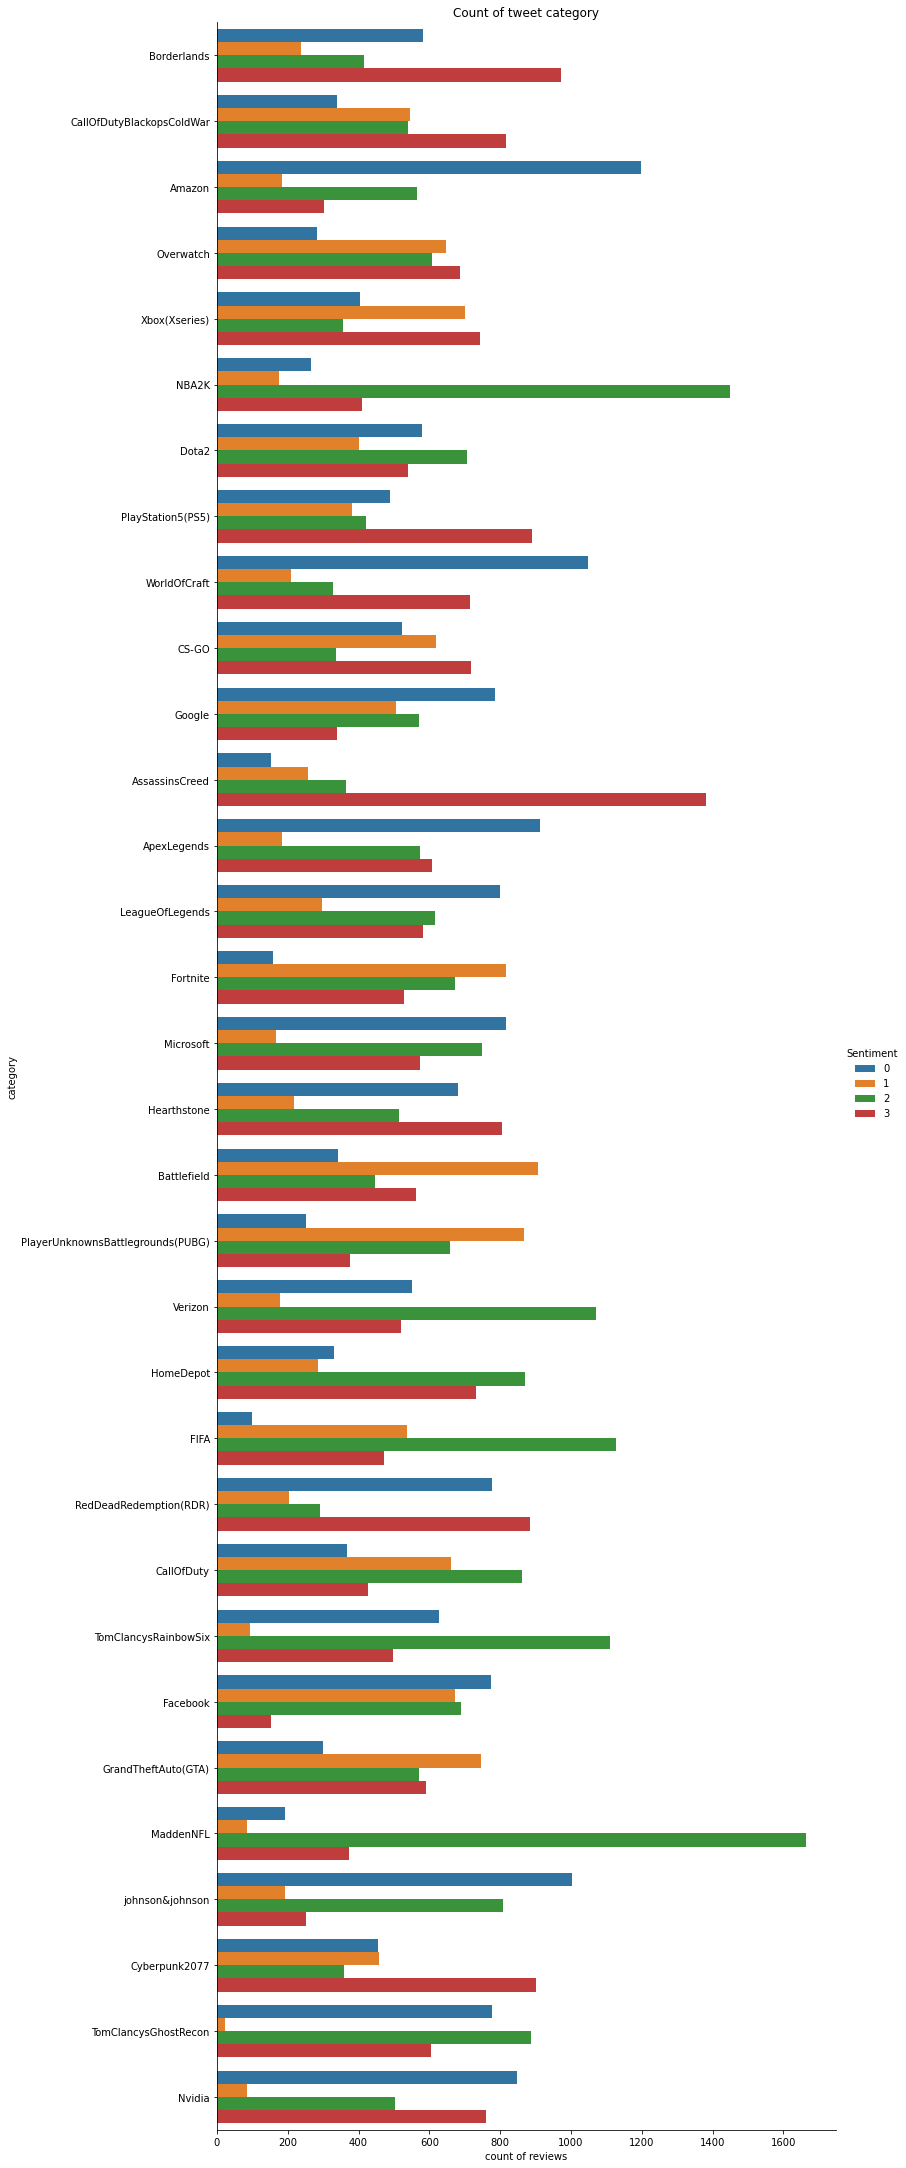

In [25]:
sns.catplot(y ='Entity',kind='count', hue = 'Sentiment', data=train_df,  height=30, aspect=0.4)
plt.ylabel("category")
plt.xlabel("count of reviews")
plt.title("Count of tweet category")

## Converting Nominal Variables

Most machine learning algorithms can't handle categorical data, so we will need to change the entity names into a numerical value. We use label encoders to handle nominal variables.

In [26]:
# Encode Categorical Columns
le = LabelEncoder()

train_df.Entity = le.fit_transform(train_df.Entity)
test_df.Entity = le.transform(test_df.Entity)

In [27]:
train_df.Entity.head()

0    4
1    4
2    4
3    4
4    4
Name: Entity, dtype: int64

# Utilizing Natural Language Processing

Before we clean the text features, we will attempt to extract some insight from the text. Below is a set of functions that looks at the counts of various aspects, such as: word, sentence, character counts.

In [28]:
def make_feature(df, feature_name_in):
    tmp_df = df.copy()
    tmp_df['char_count'] = tmp_df[feature_name_in].apply(lambda x:count_chars(x))
    tmp_df['word_count'] = tmp_df[feature_name_in].apply(lambda x:count_words(x))
    tmp_df['sent_count'] = tmp_df[feature_name_in].apply(lambda x:count_sent(x))
    tmp_df['capital_char_count'] = tmp_df[feature_name_in].apply(lambda x:count_capital_chars(x))
    tmp_df['capital_word_count'] = tmp_df[feature_name_in].apply(lambda x:count_capital_words(x))
    tmp_df['quoted_word_count'] = tmp_df[feature_name_in].apply(lambda x:count_words_in_quotes(x))
    tmp_df['stopword_count'] = tmp_df[feature_name_in].apply(lambda x:count_stopwords(x))
    tmp_df['unique_word_count'] = tmp_df[feature_name_in].apply(lambda x:count_unique_words(x))
    tmp_df['htag_count'] = tmp_df[feature_name_in].apply(lambda x:count_htags(x))
    tmp_df['mention_count'] = tmp_df[feature_name_in].apply(lambda x:count_mentions(x))
    tmp_df['punct_count'] = tmp_df[feature_name_in].apply(lambda x:count_punctuations(x))
    tmp_df['avg_wordlength']= tmp_df['char_count']/tmp_df['word_count']
    tmp_df['avg_sentlength']= tmp_df['word_count']/tmp_df['sent_count']
    tmp_df['unique_vs_words']= tmp_df['unique_word_count']/tmp_df['word_count']
    tmp_df['stopwords_vs_words']= tmp_df['stopword_count']/tmp_df['word_count']
    
    return tmp_df

In [29]:
train_df = make_feature(train_df, 'Tweet_Content')
test_df = make_feature(test_df, 'Tweet_Content')

The 'punct_count' feature is represented as a dictionary containing the number of times a certain punctuation occurs in the tweet. The below code expands the dictionary to columns.

In [30]:
def expand_punct_column(_df):
    df_punct= pd.DataFrame(list(_df.punct_count))
    
    # Merging the pnctuation DataFrame with main DataFrame
    _df=pd.merge(_df, df_punct, left_index=True, right_index=True)
    
    # We can drop "punct_count" column.
    _df.drop(columns=['punct_count'], inplace=True)
    
    return _df

In [31]:
train_df = expand_punct_column(train_df)
test_df = expand_punct_column(test_df)

In [32]:
train_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,2401,4,3,im getting on borderlands and i will murder yo...,53,11,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2401,4,3,I am coming to the borders and I will kill you...,51,12,1,2,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2401,4,3,im getting on borderlands and i will kill you ...,50,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2401,4,3,im coming on borderlands and i will murder you...,51,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2401,4,3,im getting on borderlands 2 and i will murder ...,57,12,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
test_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,3364,11,1,I mentioned on Facebook that I was struggling ...,242,47,1,6,2,0,...,0,0,0,0,0,0,0,0,0,0
1,352,0,0,BBC News - Amazon boss Jeff Bezos rejects clai...,109,16,1,7,1,0,...,0,0,0,0,0,0,0,0,0,0
2,8312,19,2,@Microsoft Why do I pay for WORD when it funct...,91,17,2,11,2,0,...,0,0,0,0,0,0,0,0,0,0
3,4371,5,2,"CSGO matchmaking is so full of closet hacking,...",71,13,1,4,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4433,13,0,Now the President is slapping Americans in the...,170,25,2,6,0,0,...,0,0,0,0,0,0,0,0,0,0


Becuase IDs are a unique identifier, they don't add value for the tweet model, so we will drop the field.

In [34]:
train_df.drop(['Tweet_ID'], inplace=True, axis=1)
test_df.drop(['Tweet_ID'], inplace=True, axis=1)

In [35]:
train_df.head()

,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,4,3,im getting on borderlands and i will murder yo...,53,11,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
1,4,3,I am coming to the borders and I will kill you...,51,12,1,2,2,0,7,...,0,0,0,0,0,0,0,0,0,0
2,4,3,im getting on borderlands and i will kill you ...,50,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
3,4,3,im coming on borderlands and i will murder you...,51,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
4,4,3,im getting on borderlands 2 and i will murder ...,57,12,1,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0


In [36]:
test_df.head()

,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,11,1,I mentioned on Facebook that I was struggling ...,242,47,1,6,2,0,26,...,0,0,0,0,0,0,0,0,0,0
1,0,0,BBC News - Amazon boss Jeff Bezos rejects clai...,109,16,1,7,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,19,2,@Microsoft Why do I pay for WORD when it funct...,91,17,2,11,2,0,7,...,0,0,0,0,0,0,0,0,0,0
3,5,2,"CSGO matchmaking is so full of closet hacking,...",71,13,1,4,1,0,5,...,0,0,0,0,0,0,0,0,0,0
4,13,0,Now the President is slapping Americans in the...,170,25,2,6,0,0,11,...,0,0,0,0,0,0,0,0,0,0


Next, we apply a fleet of functions to clean text features, remove common and remove rare words. We take out:

* Repeated characters
* Separate digits
* Slang
* Stem words
* Single characters
* Punctuations
* Extra space
* Replace digits with characters
* Emoticons
* URL
* Alphanumerics
* Stop words

In [37]:
def clean_feature(_df, feature_name):
    _df[feature_name] = _df[feature_name].apply(lambda i: appos_look_up(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_repeated_characters(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: separate_digit_text(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: slang_look_up(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: stem_text(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_single_char_word(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_punctuations(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_extra_space(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: replace_digits_with_char(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: emoticons_look_up(i)[0])
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_url(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_alphanumerics(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_stop_words(i))
    
    _df[feature_name] = _df[feature_name].apply(lambda i: ''.join(TextBlob(i).correct()))
    
    # removing common and rare words
    common = pd.Series(' '.join(_df[feature_name]).split()).value_counts()[:3]
    common = list(common.index)
    _df[feature_name] = _df[feature_name].apply(lambda i: " ".join(i for i in i.split() if i not in common))
    
    rare = pd.Series(' '.join(_df[feature_name]).split()).value_counts()[-3:]
    rare = list(rare.index)
    _df[feature_name] = _df[feature_name].apply(lambda i: " ".join(i for i in i.split() if i not in rare))
    
    
    return _df

Cleaning the text features will take a very, very long time. You can take one or two or more cups of coffee!!! :) 

In [38]:
start_time = pd.Timestamp.now()
print("The text cleaning starts now: "+str(start_time))

The text cleaning starts now: 2022-05-19 16:01:28.677975


In [39]:
train_df = clean_feature(train_df, 'Tweet_Content')
test_df = clean_feature(test_df, 'Tweet_Content')

In [40]:
end_time = pd.Timestamp.now()
print("The text cleaning finished at: "+str(end_time))

The text cleaning finished at: 2022-05-19 22:26:27.098787


In [41]:
delta = ((end_time - start_time).total_seconds())/60/60
print("The data cleaning took :"+str(delta)+" hours to complete.")

The data cleaning took :6.416228003333333 hours to complete.


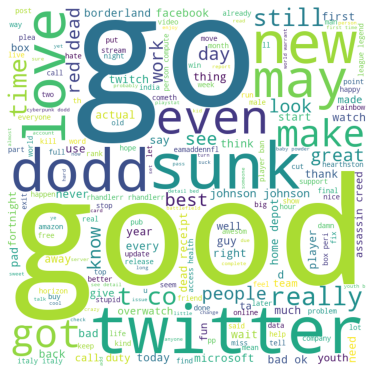

In [42]:
#WordCloud

words = '' 
for i in train_df["Tweet_Content"]: 
    tokens = i.split()   
    words += " ".join(tokens)+" "

    
word_cloud = WordCloud(width=700, height=700, background_color='white', min_font_size=10).generate(words) 
plt.figure(figsize = (5, 5)) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

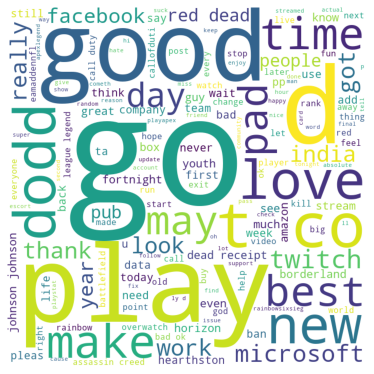

In [43]:
#WordCloud

words = '' 
for i in test_df["Tweet_Content"]: 
    tokens = i.split()   
    words += " ".join(tokens)+" "

    
word_cloud = WordCloud(width=700, height=700, background_color='white', min_font_size=10).generate(words) 
plt.figure(figsize = (5, 5)) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Saving cleaned dataframe.

In [44]:
train_df.to_csv('../data/processed/cleaned_tweet_train.csv')
test_df.to_csv('../data/processed/cleaned_tweet_test.csv')

# Training ML models

Text features are considered unstructured data. Tokenization of text document can be indirectly used for representing documents. We often need to use algorithms like, term frequency–inverse document frequency (TF-IDF) to account for token occurrences (meaning we break the sentence into words or tokens) in a document and turn an unstructured text into a numerical vector that is suitable for machine learning. There are many other techniques that can be used to convert text to numerical sequences. We will use tensorflow’s library to perform both the Tokenization and to convert to numerical vectors, known as embeddings.

# Run below code to get data from local file system. 

In [45]:
# Due to special charas should be encoded as latin 1

train_df = pd.read_csv("../data/processed/cleaned_tweet_train.csv")
train_df.drop(['Unnamed: 0'], axis=1, inplace=True)
train_df.columns = train_df.columns.str.upper() 

test_df = pd.read_csv("../data/processed/cleaned_tweet_test.csv")
test_df.drop(['Unnamed: 0'], axis=1, inplace=True)
test_df.columns = test_df.columns.str.upper() 

# Or, run below cell's to get data from Snowflake

You can establish a connection and get a Pandas DataFrame. Just fill '<...>' with your Snowflake account credentials.

In [ ]:
import snowflake.connector as sc
import snowflake.connector.pandas_tools as pt
from snowflake.connector.pandas_tools import write_pandas

In [ ]:
database = '<database name>'
schema='<schema name>'
table_name_train='SENTIMENT_ANALYSIS_TRAIN'
table_name_test='SENTIMENT_ANALYSIS_TEST'

In [ ]:
ctx = sc.connect(
    user='<user name>',
    password='<password to the database>',
    account='<account>',
    warehouse='<warehouse name>',
    database=database,
    schema=schema,
    protocol='https',
    port=443
)

In [ ]:
cur = ctx.cursor()

In [ ]:
query = cur.execute(f"SELECT * FROM <database name>.<schema name>.SENTIMENT_ANALYSIS_TRAIN")

In [ ]:
train_df = query.fetch_pandas_all()

In [ ]:
query = cur.execute(f"SELECT * FROM <database name>.<schema name>.SENTIMENT_ANALYSIS_TEST")

In [ ]:
test_df = query.fetch_pandas_all()

In [46]:
train_df.shape

(71656, 49)

In [47]:
train_df.head()

,ENTITY,SENTIMENT,TWEET_CONTENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,...,[ COUNT,\ COUNT,] COUNT,^ COUNT,_ COUNT,` COUNT,{ COUNT,| COUNT,} COUNT,~ COUNT
0,4,3,get borderland murder,53,11,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
1,4,3,border kill,51,12,1,2,2,0,7,...,0,0,0,0,0,0,0,0,0,0
2,4,3,get borderland kill,50,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
3,4,3,borderland murder,51,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
4,4,3,get borderland murder,57,12,1,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0


In [48]:
test_df.head()

,ENTITY,SENTIMENT,TWEET_CONTENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,...,[ COUNT,\ COUNT,] COUNT,^ COUNT,_ COUNT,` COUNT,{ COUNT,| COUNT,} COUNT,~ COUNT
0,11,1,mention facebook struggle motive go run day tr...,242,47,1,6,2,0,26,...,0,0,0,0,0,0,0,0,0,0
1,0,0,bc news amazon boss jeff be reject claim compa...,109,16,1,7,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,19,2,microsoft pay word function poor samsungus chr...,91,17,2,11,2,0,7,...,0,0,0,0,0,0,0,0,0,0
3,5,2,so watchman full closet hack truly a,71,13,1,4,1,0,5,...,0,0,0,0,0,0,0,0,0,0
4,13,0,preside slap american really commit law act ac...,170,25,2,6,0,0,11,...,0,0,0,0,0,0,0,0,0,0


In [49]:
n_reviews, n_attributes = train_df.shape
print('Total tweets in training dataset: ',n_reviews)
print('Total attributes in training dataset: ',n_attributes)

print('\n==============\n')

n_reviews, n_attributes = test_df.shape
print('Total tweet in testing dataset: ',n_reviews)
print('Total attributes in testing dataset: ',n_attributes)

Total tweets in training dataset:  71656
Total attributes in training dataset:  49


Total tweet in testing dataset:  1000
Total attributes in testing dataset:  49


In [50]:
train_df["TWEET_CONTENT"]

0                                    get borderland murder
1                                              border kill
2                                      get borderland kill
3                                        borderland murder
4                                    get borderland murder
                               ...                        
71651    realize window partite mac like year behind in...
71652    realize mac window partite year behind india d...
71653    realize window partite mac year behind india d...
71654    realize window partite mac like year behind in...
71655    like window partite mac like year behind drive...
Name: TWEET_CONTENT, Length: 71656, dtype: object

In [51]:
train_df["TWEET_CONTENT"] = train_df["TWEET_CONTENT"].astype(str)
test_df["TWEET_CONTENT"] = test_df["TWEET_CONTENT"].astype(str)

In [52]:
#Define the Tokeniser
tokeniser = Tokenizer(num_words=10000, lower=True)

#Create the corpus by finding the most common 
tokeniser.fit_on_texts(train_df["TWEET_CONTENT"])

In [53]:
#Tokenise our column of edited Tweet content
tweet_tokens_train = tokeniser.texts_to_sequences(list(train_df["TWEET_CONTENT"]))
tweet_tokens_test = tokeniser.texts_to_sequences(list(test_df["TWEET_CONTENT"]))

In [54]:
#Pad these sequences to make them the same length
tweet_tokens_train = pad_sequences(tweet_tokens_train, truncating='post', padding='post', maxlen=15)
tweet_tokens_test = pad_sequences(tweet_tokens_test, truncating='post', padding='post', maxlen=15)

Each row from below matrix is a numerical vector that represent one sentence from each customer tweet.

In [55]:
tweet_tokens_train

array([[   3,   79, 1171, ...,    0,    0,    0],
       [1674,  123,    0, ...,    0,    0,    0],
       [   3,   79,  123, ...,    0,    0,    0],
       ...,
       [ 710,  481, 7484, ...,    0,    0,    0],
       [ 710,  481, 7484, ...,  894,    0,    0],
       [   4,  481, 7484, ...,    0,    0,    0]], dtype=int32)

In [56]:
tweet_tokens_test

array([[ 827,   30, 1124, ...,    3,  179,  505],
       [1241,  113,   39, ..., 1241,   27,  120],
       [  52,  231,  370, ...,    0,    0,    0],
       ...,
       [  67,  226,    9, ...,    0,    0,    0],
       [ 375, 6617,   52, ...,    0,    0,    0],
       [  16,   16,   88, ..., 3114,   29,   69]], dtype=int32)

Remove the text feature from both the training and testing dataset

In [57]:
train_df.head()

,ENTITY,SENTIMENT,TWEET_CONTENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,...,[ COUNT,\ COUNT,] COUNT,^ COUNT,_ COUNT,` COUNT,{ COUNT,| COUNT,} COUNT,~ COUNT
0,4,3,get borderland murder,53,11,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
1,4,3,border kill,51,12,1,2,2,0,7,...,0,0,0,0,0,0,0,0,0,0
2,4,3,get borderland kill,50,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
3,4,3,borderland murder,51,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
4,4,3,get borderland murder,57,12,1,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0


In [58]:
test_df.head()

,ENTITY,SENTIMENT,TWEET_CONTENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,...,[ COUNT,\ COUNT,] COUNT,^ COUNT,_ COUNT,` COUNT,{ COUNT,| COUNT,} COUNT,~ COUNT
0,11,1,mention facebook struggle motive go run day tr...,242,47,1,6,2,0,26,...,0,0,0,0,0,0,0,0,0,0
1,0,0,bc news amazon boss jeff be reject claim compa...,109,16,1,7,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,19,2,microsoft pay word function poor samsungus chr...,91,17,2,11,2,0,7,...,0,0,0,0,0,0,0,0,0,0
3,5,2,so watchman full closet hack truly a,71,13,1,4,1,0,5,...,0,0,0,0,0,0,0,0,0,0
4,13,0,preside slap american really commit law act ac...,170,25,2,6,0,0,11,...,0,0,0,0,0,0,0,0,0,0


Finally, before we train the classification model, we have to combine the customer tweets with the rest of the features that we created earlier.

In [59]:
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

In [60]:
train_full_df = pd.concat([train_df, 
                           pd.DataFrame(tweet_tokens_train)], join='inner', ignore_index=False, axis=1)

test_full_df = pd.concat([test_df, 
                           pd.DataFrame(tweet_tokens_test)], join='inner', ignore_index=False, axis=1)

In [61]:
train_df = train_full_df.dropna()
test_df = test_full_df.dropna()

In [62]:
full_df = pd.concat([train_df, test_df])
polarity_df = pd.concat([train_df, test_df])
y_full = full_df.pop('SENTIMENT')
full_df.sample(5)

,ENTITY,TWEET_CONTENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,UNIQUE_WORD_COUNT,...,5,6,7,8,9,10,11,12,13,14
17848,29,massive event thank legend adesanya of middle ...,239,36,2,32,3,0,11,32,...,182,810,3042,6225,83,900,142,1931,80,1543
32566,12,go insane,28,6,1,0,0,0,3,6,...,0,0,0,0,0,0,0,0,0,0
56951,11,dumbass facebook say violence law enforce mino...,192,32,1,4,0,0,12,31,...,2424,2113,97,48,154,476,378,1626,68,151
21657,5,lost so rip stupid explode bottle fall heartra...,167,31,3,4,1,0,14,31,...,2654,369,4167,1016,151,721,565,190,6331,0
3671,7,stink jesus christ,33,6,1,4,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0


In [63]:
train_df.drop(columns=['TWEET_CONTENT'], inplace=True)
test_df.drop(columns=['TWEET_CONTENT'], inplace=True)

In [64]:
y_train = train_df.pop('SENTIMENT')
y_test = test_df.pop('SENTIMENT')

In [65]:
y_train = y_train.values
y_test = y_test.values

In [66]:
train_full_df.shape

(71656, 64)

In [67]:
test_full_df.shape

(1000, 64)

## We will be training a variety of models and compare them to each other. 
This particular dataset is unique in the fact that it has predefined labels associated with the sentiment. Because there are pre-defined classes, we can use classification techniques to build a model based on those labels. Most often when you are trying to build a sentiment anlaysis engine from scratch, there will not be labels associated with the sentiment. In this case, we can leverage unsupervised techiques to determine a polarity score to create a label.

The selected models are:
* Random-Forecast (supervised)
* LSTM (supervised)
* Polarity with TextBlob (unsupervised)

# Supervised modeling techniques

## Random-Forest classification 

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier(random_state=1)
model.fit(train_df, y_train)

y_pred = model.predict(test_df)

print("Training Accuracy :", model.score(train_df, y_train))
print("Validation Accuracy :", model.score(test_df, y_test))

Training Accuracy : 0.9894661742487829
Validation Accuracy : 0.861


In [69]:
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

The confusion matrix is a technique that summarizes the performance of a classification algorithm. The number of correct and incorrect predictions are summarized with count values and broken down by each class. 

In the confusion matrix below, the diagonal of green and yellow values show the percentage of a particular class that was predicted correctly. For example, 86% of all positive tweets were classified as such. Some other classes were incorrectly classified as positive and some positive tweets were incorrectly classified into the other categories. Overall, the correct classifications are relatively high. Negative tweets are classified correctly at the highest rate and irrelevant tweets are classified correctly at the lowest rate.



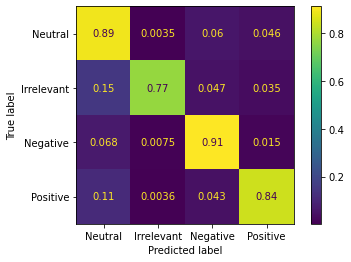

In [70]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

In [71]:
full_df

,ENTITY,TWEET_CONTENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,UNIQUE_WORD_COUNT,...,5,6,7,8,9,10,11,12,13,14
0,4,get borderland murder,53,11,1,0,0,0,6,11,...,0,0,0,0,0,0,0,0,0,0
1,4,border kill,51,12,1,2,2,0,7,11,...,0,0,0,0,0,0,0,0,0,0
2,4,get borderland kill,50,10,1,0,0,0,6,10,...,0,0,0,0,0,0,0,0,0,0
3,4,borderland murder,51,10,1,0,0,0,6,10,...,0,0,0,0,0,0,0,0,0,0
4,4,get borderland murder,57,12,1,0,0,0,7,12,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,14,⭐️ toronto art culture capital canada wonder s...,281,47,3,9,1,0,21,43,...,338,84,430,242,168,81,183,2211,412,256
996,5,actual good move bring viewer people got hook ...,248,46,4,44,10,0,14,45,...,14,26,2118,91,56,818,62,3998,10,25
997,4,today suck time drink wine play borderland sun...,120,24,1,2,1,0,11,23,...,3998,79,943,146,37,426,0,0,0,0
998,19,bought fraction microsoft today small win,49,8,2,3,0,0,2,8,...,100,0,0,0,0,0,0,0,0,0


In [72]:
# Apply the model and write out to visualize
rf_full = full_df
rf_full = rf_full.reset_index()
# rf_tweets = rf_full[['index','TWEET_CONTENT']]
rf_sub = rf_full.drop(columns={'index', 'TWEET_CONTENT'})

y_full_pred = model.predict(rf_sub)
y_full_pred_labels = ids_to_names(y_full_pred)
y_full_actual_labels = ids_to_names(y_full)

rf_predicted = pd.DataFrame(y_full_pred_labels).reset_index()
rf_predicted = rf_predicted.rename(columns={0:'PREDICTED_SENTIMENT'})

rf_actuals = pd.DataFrame(y_full_actual_labels).reset_index()
rf_actuals = rf_actuals.rename(columns={0:'ACTUAL_SENTIMENT'})


rf_full = rf_full.merge(rf_actuals, on=['index'], how='left')
rf_full = rf_full.merge(rf_predicted, on=['index'], how='left')

rf_full.to_csv('../data/applied_models/random_forest_results.csv')

rf_full.head()

,index,ENTITY,TWEET_CONTENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,...,7,8,9,10,11,12,13,14,ACTUAL_SENTIMENT,PREDICTED_SENTIMENT
0,0,4,get borderland murder,53,11,1,0,0,0,6,...,0,0,0,0,0,0,0,0,Positive,Positive
1,1,4,border kill,51,12,1,2,2,0,7,...,0,0,0,0,0,0,0,0,Positive,Positive
2,2,4,get borderland kill,50,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,Positive,Positive
3,3,4,borderland murder,51,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,Positive,Positive
4,4,4,get borderland murder,57,12,1,0,0,0,7,...,0,0,0,0,0,0,0,0,Positive,Positive


## LSTM classification Supervised modeling techniques

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation. This architecture use two bidirectional RNN layer, before a dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).

<img src="images/bidirectional_rnn_model.png" width="80%">

In [73]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000, 16, input_length=train_df.shape[1]),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
tf.keras.layers.Dense(4, activation='softmax')
])

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
     loss=loss_function,
     optimizer='adam',
     metrics=['accuracy']
)

Metal device set to: Apple M1


2022-05-19 22:28:41.435104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-19 22:28:41.439199: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [74]:
h = model.fit(
    train_df, y_train,
    validation_data=(test_df, y_test),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)]
)

Epoch 1/20


2022-05-19 22:28:42.675143: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-19 22:28:44.965649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 22:28:45.541299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 22:28:45.568539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 22:28:46.737186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 22:28:46.747430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 22:28:48.287983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

2234/2234 [==============================] - ETA: 0s - loss: 0.9718 - accuracy: 0.5916

2022-05-19 23:02:40.679673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 23:02:40.823805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 23:02:40.830816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 23:02:40.953654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 23:02:40.961467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2234/2234 [==============================] - 2040s 910ms/step - loss: 0.9718 - accuracy: 0.5916 - val_loss: 0.5504 - val_accuracy: 0.8080
Epoch 2/20
2234/2234 [==============================] - 2589s 1s/step - loss: 0.6112 - accuracy: 0.7692 - val_loss: 0.3672 - val_accuracy: 0.8810
Epoch 3/20
2234/2234 [==============================] - 1136s 509ms/step - loss: 0.4762 - accuracy: 0.8226 - val_loss: 0.3447 - val_accuracy: 0.8810
Epoch 4/20
2234/2234 [==============================] - 139s 62ms/step - loss: 0.4079 - accuracy: 0.8477 - val_loss: 0.2848 - val_accuracy: 0.9040
Epoch 5/20
2234/2234 [==============================] - 140s 63ms/step - loss: 0.3609 - accuracy: 0.8642 - val_loss: 0.2627 - val_accuracy: 0.9160
Epoch 6/20
2234/2234 [==============================] - 141s 63ms/step - loss: 0.3244 - accuracy: 0.8790 - val_loss: 0.2742 - val_accuracy: 0.9180
Epoch 7/20
2234/2234 [==============================] - 141s 63ms/step - loss: 0.2942 - accuracy: 0.8902 - val_loss: 0.2655 - 

In [75]:
#Generate predictions
y_pred = np.argmax(model.predict(test_df), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

2022-05-20 00:44:39.045456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-20 00:44:39.201844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-20 00:44:39.222404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-20 00:44:39.462933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-20 00:44:39.471852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


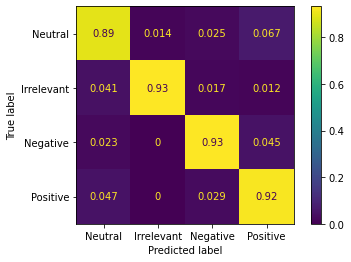

In [76]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

In [77]:
# Apply the model and write out to visualize
lstm_full = full_df
lstm_full = lstm_full.reset_index()
lstm_sub = lstm_full.drop(columns={'index', 'TWEET_CONTENT'})

y_full_pred = np.argmax(model.predict(lstm_sub), axis=1)
y_full_pred_labels = ids_to_names(y_full_pred)
y_full_actual_labels = ids_to_names(y_full)

lstm_predicted = pd.DataFrame(y_full_pred_labels).reset_index()
lstm_predicted = lstm_predicted.rename(columns={0:'PREDICTED_SENTIMENT'})

lstm_actuals = pd.DataFrame(y_full_actual_labels).reset_index()
lstm_actuals = lstm_actuals.rename(columns={0:'ACTUAL_SENTIMENT'})

lstm_full = lstm_full.merge(lstm_actuals, on=['index'], how='left')
lstm_full = lstm_full.merge(lstm_predicted, on=['index'], how='left')

lstm_full.to_csv('../data/applied_models/lstm_results.csv')

lstm_full


,index,ENTITY,TWEET_CONTENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,...,7,8,9,10,11,12,13,14,ACTUAL_SENTIMENT,PREDICTED_SENTIMENT
0,0,4,get borderland murder,53,11,1,0,0,0,6,...,0,0,0,0,0,0,0,0,Positive,Positive
1,1,4,border kill,51,12,1,2,2,0,7,...,0,0,0,0,0,0,0,0,Positive,Positive
2,2,4,get borderland kill,50,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,Positive,Positive
3,3,4,borderland murder,51,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,Positive,Positive
4,4,4,get borderland murder,57,12,1,0,0,0,7,...,0,0,0,0,0,0,0,0,Positive,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72479,995,14,⭐️ toronto art culture capital canada wonder s...,281,47,3,9,1,0,21,...,430,242,168,81,183,2211,412,256,Neutral,Neutral
72480,996,5,actual good move bring viewer people got hook ...,248,46,4,44,10,0,14,...,2118,91,56,818,62,3998,10,25,Neutral,Neutral
72481,997,4,today suck time drink wine play borderland sun...,120,24,1,2,1,0,11,...,943,146,37,426,0,0,0,0,Positive,Positive
72482,998,19,bought fraction microsoft today small win,49,8,2,3,0,0,2,...,0,0,0,0,0,0,0,0,Positive,Positive


It is evident from the above results that deep learning yields higher performance with an average of 93% compared to using Random-Forest classification model that yields an average of 86.9%. That is a 6.1% improvement.

# Save and load deep learning model

In [78]:
filename = '../models/finalized_model_proposed.h5'

In [79]:
model.save(filename)

In [80]:
del model  # deletes the existing model

In [81]:
# returns a compiled model
model = load_model(filename)

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 62, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 62, 100)          26800     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 247,604
Trainable params: 247,604
Non-trainable params: 0
_________________________________________________________________


In [83]:
#Generate predictions
y_pred = np.argmax(model.predict(test_df), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

2022-05-20 06:48:25.047427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-20 06:48:25.256202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-20 06:48:25.281112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-20 06:48:25.525457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-20 06:48:25.534479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


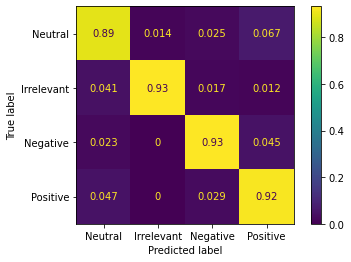

In [84]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

In [85]:
# Apply the model and write out to visualize
lstm_full = full_df
lstm_full = lstm_full.reset_index()
lstm_sub = lstm_full.drop(columns={'index', 'TWEET_CONTENT'})

y_full_pred = np.argmax(model.predict(lstm_sub), axis=1)
y_full_pred_labels = ids_to_names(y_full_pred)
y_full_actual_labels = ids_to_names(y_full)

lstm_predicted = pd.DataFrame(y_full_pred_labels).reset_index()
lstm_predicted = lstm_predicted.rename(columns={0:'PREDICTED_SENTIMENT'})

lstm_actuals = pd.DataFrame(y_full_actual_labels).reset_index()
lstm_actuals = lstm_actuals.rename(columns={0:'ACTUAL_SENTIMENT'})


lstm_full = lstm_full.merge(lstm_actuals, on=['index'], how='left')
lstm_full = lstm_full.merge(lstm_predicted, on=['index'], how='left')

lstm_full.to_csv('../data/applied_models/lstm_results.csv')

lstm_full.head()

,index,ENTITY,TWEET_CONTENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,...,7,8,9,10,11,12,13,14,ACTUAL_SENTIMENT,PREDICTED_SENTIMENT
0,0,4,get borderland murder,53,11,1,0,0,0,6,...,0,0,0,0,0,0,0,0,Positive,Positive
1,1,4,border kill,51,12,1,2,2,0,7,...,0,0,0,0,0,0,0,0,Positive,Positive
2,2,4,get borderland kill,50,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,Positive,Positive
3,3,4,borderland murder,51,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,Positive,Positive
4,4,4,get borderland murder,57,12,1,0,0,0,7,...,0,0,0,0,0,0,0,0,Positive,Positive


# Unsupervised techniques

In the case that there are no labels associated with your data, you can create them with unsupervised learning. In this experiment, we will use TextBlob’s output for a polarity. This output is a float within the range [-1.0, 1.0], where -1.0 is a negative polarity and 1.0 is positive. This score can also be equal to 0, which stands for a neutral evaluation of a statement as it doesn’t contain any words from the training set.

In [86]:
# Due to special charas should be encoded as latin 1

train_tweet_df = pd.read_csv("../data/processed/cleaned_tweet_train.csv")
train_tweet_df.drop(['Unnamed: 0'], axis=1, inplace=True)

test_tweet_df = pd.read_csv("../data/processed/cleaned_tweet_test.csv")
test_tweet_df.drop(['Unnamed: 0'], axis=1, inplace=True)

For this model, we can use the raw Tweet content rather than the engineered values. This can help us to understand the grouping of the tweets and the possible label. We remove the missing values and input them into the model to get the polarity score.

In [87]:
train_tweet_df["Tweet_Content"] = train_tweet_df["Tweet_Content"].astype(str)
test_tweet_df["Tweet_Content"] = test_tweet_df["Tweet_Content"].astype(str)

In [88]:
train_tweet_df = train_tweet_df.dropna()
test_tweet_df = test_tweet_df.dropna()

In [89]:
train_tweet_df.head()

,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,4,3,get borderland murder,53,11,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
1,4,3,border kill,51,12,1,2,2,0,7,...,0,0,0,0,0,0,0,0,0,0
2,4,3,get borderland kill,50,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
3,4,3,borderland murder,51,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
4,4,3,get borderland murder,57,12,1,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0


In [90]:
train_tweet_df['Tweet_Content']

0                                    get borderland murder
1                                              border kill
2                                      get borderland kill
3                                        borderland murder
4                                    get borderland murder
                               ...                        
71651    realize window partite mac like year behind in...
71652    realize mac window partite year behind india d...
71653    realize window partite mac year behind india d...
71654    realize window partite mac like year behind in...
71655    like window partite mac like year behind drive...
Name: Tweet_Content, Length: 71484, dtype: object

The below function returns the polarity (score) from the text feature. 

In [91]:
def sentiment(text):
    senti =TextBlob(text)
    return senti.sentiment

test_tweet_df['polarity']=test_tweet_df['Tweet_Content'].apply(sentiment).apply(lambda b: b[0])

test_tweet_df.head()

,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count,polarity
0,11,1,mention facebook struggle motive go run day tr...,242,47,1,6,2,0,26,...,0,0,0,0,0,0,0,0,0,0.0125
1,0,0,bc news amazon boss jeff be reject claim compa...,109,16,1,7,1,0,1,...,0,0,0,0,0,0,0,0,0,0.0000
2,19,2,microsoft pay word function poor samsungus chr...,91,17,2,11,2,0,7,...,0,0,0,0,0,0,0,0,0,-0.4000
3,5,2,so watchman full closet hack truly a,71,13,1,4,1,0,5,...,0,0,0,0,0,0,0,0,0,0.3500
4,13,0,preside slap american really commit law act ac...,170,25,2,6,0,0,11,...,0,0,0,0,0,0,0,0,0,0.3000


For simplicity, we remove the Irrelevant sentiment class. The polarity is used to classify one of these classes: neutral, Negative, or positive.

In [92]:
test_tweet_df = test_tweet_df[test_tweet_df.Sentiment.isin([0, 2, 3])]

"Neutral":0, "Irrelevant":1, "Negative":2, "Positive": 3

In [93]:
def categories(pol):
    if pol == 0:
        return 0
    elif pol < 0:
        return 2
    else:
        return 3
    
    
test_tweet_df['pd_sentiment']=test_tweet_df['polarity'].apply(categories)
test_tweet_df.head()

,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,] count,^ count,_ count,` count,{ count,| count,} count,~ count,polarity,pd_sentiment
1,0,0,bc news amazon boss jeff be reject claim compa...,109,16,1,7,1,0,1,...,0,0,0,0,0,0,0,0,0.00000,0
2,19,2,microsoft pay word function poor samsungus chr...,91,17,2,11,2,0,7,...,0,0,0,0,0,0,0,0,-0.40000,2
3,5,2,so watchman full closet hack truly a,71,13,1,4,1,0,5,...,0,0,0,0,0,0,0,0,0.35000,3
4,13,0,preside slap american really commit law act ac...,170,25,2,6,0,0,11,...,0,0,0,0,0,0,0,0,0.30000,3
5,10,2,hi help mallein mann cellar past year little s...,268,52,1,10,1,0,27,...,0,0,0,0,0,0,0,0,-0.21875,2


When we compare the outcomes of the polarity scoring with the tagged values, the model accuracy is only 41%. This isn’t necessarily a bad thing because the goal of an unsupervised method is to create labels where there are none. Also in this specific example, there are a lot of tweets about video games. What might traditionally be seen as negative sentiment in another situation may actually be positive sentiment for video games. Utilizing unsupervised learning is a starting point to create labels. Refinement of those labels happens through recommendation engines and building custom libraries with keywords and their associations.

In [94]:
accuracy_score(test_tweet_df.pd_sentiment, test_tweet_df.Sentiment)

0.41183574879227053

Plot the sentiment with WordCloud

In [95]:
pos_riv=test_tweet_df[test_tweet_df['pd_sentiment']== 3]
pos_riv=pos_riv[pos_riv['polarity']>0]
print(pos_riv)
print(len(pos_riv))

     Entity  Sentiment                                      Tweet_Content  \
3         5          2               so watchman full closet hack truly a   
4        13          0  preside slap american really commit law act ac...   
6        18          3  thank eamaddennfl new austin cooper rang brown...   
7        27          3  rocket league thief rainbow six siege🤔 love pl...   
10        9          3  profession data scene explode complete welcome...   
..      ...        ...                                                ...   
988      17          0  ♥️ suikoden d️⃣ flex kind miracle world person...   
989      16          3  thank match fund home depot re payment dddddd ...   
990      27          3  tom chance rainbow six sing great play neat we...   
994      23          3     good son much see new pad go right much import   
998      19          3          bought fraction microsoft today small win   

     char_count  word_count  sent_count  capital_char_count  \
3           

In [96]:
all_positive=" ".join(pos_riv['Tweet_Content'])

In [97]:
st_words=set(stopwords.words('english'))
st_words.update(['cnnpolitics','CNN','one','also','still','however','become'])

In [98]:
po_wcloud=WordCloud(width = 1000, height = 1000, 
                    background_color ='white', 
                    stopwords = st_words, 
                    min_font_size = 10).generate(all_positive)

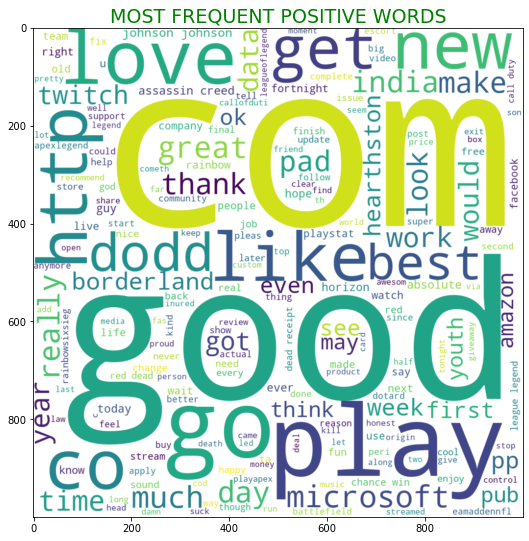

In [99]:
plt.figure(figsize=(12,9))
plt.title("MOST FREQUENT POSITIVE WORDS",fontdict={'color':"green",'fontsize':19})
plt.imshow(po_wcloud,interpolation='bilinear')
plt.show()

In [100]:
# negative
neg_riv=test_tweet_df[test_tweet_df['pd_sentiment'] == 2]
neg_riv=neg_riv[neg_riv['polarity']<0]
print(neg_riv)
print(neg_riv)

     Entity  Sentiment                                      Tweet_Content  \
2        19          2  microsoft pay word function poor samsungus chr...   
5        10          2  hi help mallein mann cellar past year little s...   
14       20          2           bad ok suck second left team intent foul   
21       15          0  anyone play bad luck albatross deck hearthston...   
29        4          2     borderland submit complaint co pay staff bonus   
..      ...        ...                                                ...   
976       6          3   quarante got bore play call duty anyone wan call   
977      13          0  odd good suggest dead terrors attack commit us...   
985      25          0  th__man play red dead redemption oh bear start...   
991       6          0  late night stream boy watch watson run struggl...   
997       4          3  today suck time drink wine play borderland sun...   

     char_count  word_count  sent_count  capital_char_count  \
2           

In [101]:
all_negative=" ".join(neg_riv['Tweet_Content'])

In [102]:
neg_wcloud=WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = st_words, 
                min_font_size = 10).generate(all_negative)

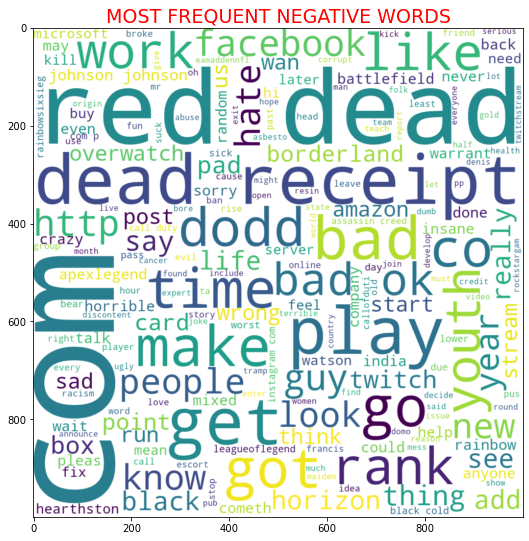

In [103]:
plt.figure(figsize=(12,9))
plt.title("MOST FREQUENT NEGATIVE WORDS",fontdict={'color':'red','fontsize':19})
plt.imshow(neg_wcloud,interpolation='bilinear')
plt.show()

In [104]:
# negative
neg_riv=test_tweet_df[test_tweet_df['pd_sentiment'] == 0]
neg_riv=neg_riv[neg_riv['polarity'] == 0]
print(neg_riv)
print(neg_riv)

     Entity  Sentiment                                      Tweet_Content  \
1         0          0  bc news amazon boss jeff be reject claim compa...   
8         2          3  still kneedeep assassin creed odyssey way anti...   
9         6          2  fix jesus pleas fix world go playstat askplays...   
11        2          3  pitch assassin tccgif assassinscreedblackflag ...   
12       28          2  fredtjoseph hey fred coast cut call horizon st...   
..      ...        ...                                                ...   
981      29          3                           warcraftdev would inured   
983       9          2                                                nan   
992       9          3                                        guess broke   
993       0          2  pleas explain possible let company overcharg s...   
999      31          0  johnson johnson stop sell talk baby powder can...   

     char_count  word_count  sent_count  capital_char_count  \
1           

In [105]:
all_neutral =" ".join(neg_riv['Tweet_Content'])

In [106]:
neg_wcloud=WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = st_words, 
                min_font_size = 10).generate(all_neutral)

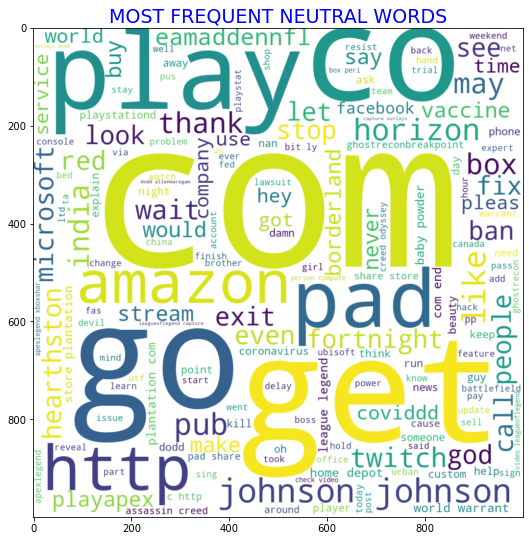

In [107]:
plt.figure(figsize=(12,9))
plt.title("MOST FREQUENT NEUTRAL WORDS",fontdict={'color':'blue','fontsize':19})
plt.imshow(neg_wcloud,interpolation='bilinear')
plt.show()

In [108]:
# Apply the polarity model to the entire dataframe
polarity_full = polarity_df
polarity_full['POLARITY'] = polarity_full['TWEET_CONTENT'].apply(sentiment).apply(lambda b: b[0])
polarity_full['PREDICTED_SENTIMENT'] = polarity_full['POLARITY'].apply(categories)

polarity_full['PREDICTED_SENTIMENT'] = ids_to_names(polarity_full['PREDICTED_SENTIMENT'])
polarity_full = polarity_full.rename(columns={'SENTIMENT': 'ACTUAL_SENTIMENT'})

polarity_full.to_csv('../data/applied_models/polarity_results.csv')

polarity_full.head(5)

,ENTITY,ACTUAL_SENTIMENT,TWEET_CONTENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,...,7,8,9,10,11,12,13,14,POLARITY,PREDICTED_SENTIMENT
0,4,3,get borderland murder,53,11,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0.0,Neutral
1,4,3,border kill,51,12,1,2,2,0,7,...,0,0,0,0,0,0,0,0,0.0,Neutral
2,4,3,get borderland kill,50,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0.0,Neutral
3,4,3,borderland murder,51,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0.0,Neutral
4,4,3,get borderland murder,57,12,1,0,0,0,7,...,0,0,0,0,0,0,0,0,0.0,Neutral


# Summary

Now that we have a saved model. you can deploy it into your infrastructure. This model can help you to:

* Improve customer service
Enable the business to respond to issues promptly before the customer churn to competitor. 
* Boost product and services
This is where issues and bugs are reported by customers as a priceless feedback loop. Therefore, performing the sentiment analysis on the customer reviews can help businesses to identify what is lacking, which should lead to improvement.
* Better marketing campaigns
Companies can get powerful insights from industry trends by analyzing sentiment towards new features or products on social media to boost marketing strategy.

If you find this information helpful and would like to learn more about ML models, feel free to [reach out to the phData ML team](https://www.phdata.io/contact-us/). We’re here to help!